In [1]:
import numpy as np
import os
os.environ['DDE_BACKEND'] = 'pytorch'
# pip install --user flax deepxde
# flax is a jax neural network library deepxde uses, might not need it if you already have tensorflow or pytorch
import deepxde as dde
import matplotlib.pyplot as plt

Using backend: pytorch
Other supported backends: tensorflow.compat.v1, tensorflow, jax, paddle.
paddle supports more examples now and is recommended.


In [77]:
def gen_random_poly(degree=4):
    coeffs = (np.random.rand(degree)-.5)*2
    poly = np.polynomial.Polynomial(coeffs)
    return poly

poly = gen_random_poly()
poly(np.linspace(1, 5, 10))

def gen_derivatives(X, n):
    """ generate [u_i(X)], [v_i(X)] s.t. v_i = du_i/dx"""
    polys = [gen_random_poly() for _ in range(n)]
    uX = [f(X)
          for poly in polys
          for f in [poly, lambda x: np.sin(poly(x))]
         ]
    vX = [df(X)
          for poly in polys
          for df in [poly.deriv(), lambda x: np.cos(poly(x))*poly.deriv()(x)]
         ]
    return np.array(uX).astype(np.float32), np.array(vX).astype(np.float32)


In [93]:

#build dataset and setup model
# following terminology from https://deepxde.readthedocs.io/en/latest/demos/operator/antiderivative_aligned.html
N_u = 300 #number of grid points
dataset_size = 2000 # number of fields to train
m_test = 1000
dim_x = 1
X = np.linspace(-5, 5, N_u)
uX_train, vX_train = gen_derivatives(X, dataset_size)
uX_test, vX_test = gen_derivatives(X, m_test)
# pytorch backend seem to need data in float32
X, uX_train, vX_train, uX_test, vX_test = \
    map(lambda y: y.astype(np.float32),
        [X.reshape(N_u, dim_x), uX_train, vX_train, uX_test, vX_test])
data = dde.data.TripleCartesianProd(
    X_train=(vX_train, X), y_train=uX_train, X_test=(vX_test, X), y_test=uX_test)

# specify network configuration
branch_network = [N_u, 40, 40, 40] # number of nodes per layer
trunk_network = [dim_x, 40, 40, 40]
net = dde.nn.DeepONetCartesianProd(branch_network, trunk_network, 'relu', 'Glorot normal')
#net((vX_train, X))

# train model
model = dde.Model(data, net)
model.compile("adam", lr=0.001, metrics=["mean l2 relative error"])


Compiling model...
'compile' took 0.000180 s



Training model...

Step      Train loss    Test loss     Test metric   
0         [2.71e+02]    [2.79e+02]    [4.70e+00]    
1000      [6.41e-01]    [8.16e-01]    [7.49e-01]    
2000      [4.84e-01]    [6.04e-01]    [6.57e-01]    
3000      [4.41e-01]    [5.34e-01]    [6.16e-01]    
4000      [4.21e-01]    [5.00e-01]    [5.93e-01]    
5000      [4.07e-01]    [4.79e-01]    [5.77e-01]    
6000      [4.24e-01]    [4.97e-01]    [5.65e-01]    
7000      [3.87e-01]    [4.49e-01]    [5.50e-01]    
8000      [3.87e-01]    [4.46e-01]    [5.38e-01]    
9000      [3.68e-01]    [4.24e-01]    [5.28e-01]    
10000     [4.02e-01]    [4.62e-01]    [5.23e-01]    
11000     [4.09e-01]    [4.64e-01]    [5.21e-01]    
12000     [4.67e-01]    [5.22e-01]    [5.17e-01]    
13000     [3.61e-01]    [4.18e-01]    [5.09e-01]    
14000     [4.03e-01]    [4.55e-01]    [5.06e-01]    
15000     [3.46e-01]    [4.03e-01]    [5.02e-01]    
16000     [3.47e-01]    [4.09e-01]    [4.99e-01]    
17000     [5.11e-01]    [5.

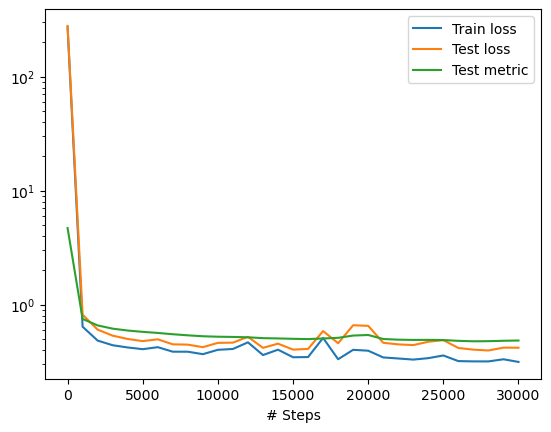

In [94]:
# train model and plot the loss trajectory
losshistory, train_state = model.train(iterations=30000)
dde.utils.plot_loss_history(losshistory)
#plt.show()

0.84159442 - 0.08915359·x - 0.88681113·x² - 0.59095364·x³
(300,)


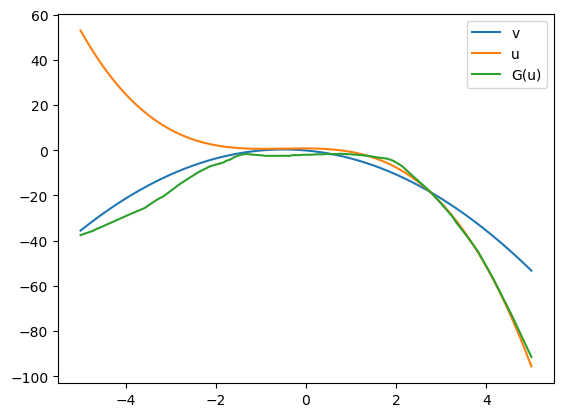

In [95]:
# play around with results
poly = gen_random_poly()
print(poly)
u = poly(X)
pred = model.predict((u.reshape(1, N_u), X)).reshape(-1)
print(np.shape(pred))

v = poly.deriv()(X)
plt.plot(X, v, label='v')
plt.plot(X, u, label='u')
plt.plot(X, pred, label='G(u)')
plt.legend()